In [31]:
import xml.etree.ElementTree as ET
import pandas as pd

# XML 파일 경로
xml_path = "mbom_250721.xml"

# XML 파싱
tree = ET.parse(xml_path)
root = tree.getroot()

# 공정 정보 파싱 함수
def parse_processes(root):
    process_list = []
    for process in root.findall(".//Process"):
        pid = process.attrib.get("id")
        ptype = process.findtext("Type")
        detail = process.findtext("Detail")
        material = process.findtext("Material")
        component_id_elem = process.find(".//Component/ID")
        component_id = component_id_elem.text if component_id_elem is not None else None
        
        estimates = process.find("Estimates")
        if estimates is not None:
            time = float(estimates.findtext("Time"))
            cost = float(estimates.findtext("Cost"))
            co2 = float(estimates.findtext("CarbonEmission"))
        else:
            time, cost, co2 = None, None, None  # 예: 조립 공정 A1

        process_list.append({
            "ProcessID": pid,
            "Type": ptype,
            "Detail": detail,
            "Material": material,
            "ComponentID": component_id,
            "Time": time,
            "Cost": cost,
            "CO2": co2
        })
    return pd.DataFrame(process_list)

# 공정 테이블 생성
df_processes = parse_processes(root)

# 확인
df_processes.head()


,ProcessID,Type,Detail,Material,ComponentID,Time,Cost,CO2
0,P1,프레스,PO T4.5 FineBlanking,PO산세도유강판,Supportor_1,20.0,5.0,10.0
1,P2,절삭,CNC밀링 PO T4.5,PO산세도유강판,Supportor_1,30.0,10.0,15.0
2,P3,프레스,PO T4.5 FineBlanking,PO산세도유강판,Bracket_1,20.0,5.0,10.0
3,P4,절삭가공,CNC밀링 PO T4.5,PO산세도유강판,Bracket_1,30.0,10.0,15.0
4,P5,절삭가공,CNC 선반,SWCH10A 냉간압조용탄소강선,Shaft_1,20.0,5.0,10.0


In [32]:
# 사용할 공정 ID 정의 (조립 포함)
selected_process_ids = ["P2", "P4", "P5", "P8", "P10", "P12"]
final_assembly_id = "A1"

# 선택한 공정만 필터링
df_selected = df_processes[df_processes["ProcessID"].isin(selected_process_ids)].copy()

# 조립 노드 수동 추가 (시간/비용/CO2 없음)
df_selected = pd.concat([
    df_selected,
    pd.DataFrame([{
        "ProcessID": final_assembly_id,
        "Type": "조립",
        "Detail": "사용자정의 조립",
        "Material": None,
        "ComponentID": None,
        "Time": None,
        "Cost": None,
        "CO2": None
    }])
], ignore_index=True)

# 노드 리스트 생성
node_list = df_selected["ProcessID"].tolist()

# 엣지 정의
edges = [
    ("P8", "P10"),  # Washer → Bush
    ("P2", final_assembly_id),
    ("P4", final_assembly_id),
    ("P5", final_assembly_id),
    ("P8", final_assembly_id),
    ("P10", final_assembly_id),
    ("P12", final_assembly_id)
]

# 확인
print("노드 목록:", node_list)
print("엣지 목록:")
for src, tgt in edges:
    print(f"  {src} → {tgt}")


노드 목록: ['P2', 'P4', 'P5', 'P8', 'P10', 'P12', 'A1']
엣지 목록:
  P8 → P10
  P2 → A1
  P4 → A1
  P5 → A1
  P8 → A1
  P10 → A1
  P12 → A1


C:\Users\roux\AppData\Local\Temp\ipykernel_39412\888002136.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_selected = pd.concat([


In [33]:
import torch

# 노드 인덱스 매핑 (PyG에서 숫자 인덱스로 처리해야 하므로)
node2idx = {pid: idx for idx, pid in enumerate(node_list)}

# edge_index 생성 (2 x num_edges)
edge_index = torch.tensor([
    [node2idx[src] for src, tgt in edges],
    [node2idx[tgt] for src, tgt in edges]
], dtype=torch.long)

# 노드 feature vector: 현재는 시간, 비용, CO2만 사용 (없으면 0)
features = []
for _, row in df_selected.iterrows():
    features.append([
        row["Time"] if row["Time"] is not None else 0.0,
        row["Cost"] if row["Cost"] is not None else 0.0,
        row["CO2"] if row["CO2"] is not None else 0.0
    ])
x = torch.tensor(features, dtype=torch.float)

# 확인
print("edge_index:\n", edge_index)
print("x (node feature tensor):\n", x)


edge_index:
 tensor([[3, 0, 1, 2, 3, 4, 5],
        [4, 6, 6, 6, 6, 6, 6]])
x (node feature tensor):
 tensor([[30., 10., 15.],
        [30., 10., 15.],
        [20.,  5., 10.],
        [30., 10., 15.],
        [30., 10., 15.],
        [30., 10., 15.],
        [nan, nan, nan]])


In [34]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# AAS XML 폴더 경로 설정 (수정 필요)
aas_folder = "D:/Project/Alchemist/AAS_v1/AAS_All"  # Windows 경로일 경우 r-string 사용

# 네임스페이스 선언
ns = {"aas": "http://www.admin-shell.io/aas/3/0"}

# 유연한 Property 파서 (AssetID 없어도 수집)
def parse_flexible_properties(root):
    props = root.findall(".//aas:submodelElements/aas:Property", ns)
    info = {}
    for p in props:
        key_elem = p.find("aas:idShort", ns)
        val_elem = p.find("aas:value", ns)
        if key_elem is not None and val_elem is not None:
            key = key_elem.text.strip()
            val = val_elem.text.strip()
            info[key] = val
    return info if info else None

# AAS 파일 순회 및 정보 수집
aas_data = []
failed_files = []

for file in os.listdir(aas_folder):
    if file.endswith(".xml"):
        path = os.path.join(aas_folder, file)
        try:
            tree = ET.parse(path)
            root = tree.getroot()
            info = parse_flexible_properties(root)
            if info:
                info["FileName"] = file  # 파일명 저장
                aas_data.append(info)
            else:
                failed_files.append((file, "No extractable <Property>"))
        except Exception as e:
            failed_files.append((file, str(e)))

# 결과 DataFrame 생성
df_aas = pd.DataFrame(aas_data).fillna("N/A")

# 출력 컬럼 설정
display_columns = ['AssetID', 'AssetType', 'Location', 'ManufacturerName', 'FileName']
for col in display_columns:
    if col not in df_aas.columns:
        df_aas[col] = "N/A"

df_display = df_aas[display_columns]

# pandas 출력 옵션: 전체 행/열 표시
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', None)

# Location이 유효한 설비만 필터링
df_aas = df_aas[df_aas["Location"] != "N/A"].reset_index(drop=True)

# 다시 출력용 DataFrame 정리
df_display = df_aas[display_columns]

print(f"유효한 위치(Location)을 가진 설비 수: {len(df_display)}개")


# 전체 설비 정보 표 출력
from IPython.display import display
display(df_display)


유효한 위치(Location)을 가진 설비 수: 132개


,AssetID,AssetType,Location,ManufacturerName,FileName
0,BTS-AP-001,자동조립,"인천광역시 연수구 송도미래로30, 스마트밸리 지식산업센터 B동 614/615/619/620호",㈜비텍스,AAS_BTS-AP-001.xml
1,BTS-AP-002,자동조립,"인천광역시 연수구 송도미래로30, 스마트밸리 지식산업센터 B동 614/615/619/620호",㈜비텍스,AAS_BTS-AP-002.xml
2,CHJ-CML-001,CNC밀링,"경기도 시흥시 희망공원로 226 (정왕동, 107호)",창화정공,AAS_CHJ-CML-001.xml
3,CRM-AM-001,PBF,"서울특별시 강서구 양천로 551-17, 1301호~1303호 (가양동,한화비즈메트로 1차)",캐리마,AAS_CRM-AM-001.xml
4,CSM-CML-001,CNC밀링,경기도 시흥시 수인로3087번길 72,코스맥,AAS_CSM-CML-001.xml
5,CSM-CML-002,CNC밀링,경기도 시흥시 수인로3087번길 72,코스맥,AAS_CSM-CML-002.xml
6,CSM-CML-003,CNC밀링,경기도 시흥시 수인로3087번길 72,코스맥,AAS_CSM-CML-003.xml
7,DGN-AM-001,PBF,경상남도 창원시 의창구 사화로 138 (팔용동 42-3번지),대건,AAS_DGN-AM-001.xml
8,DGN-AM-002,PBF,경상남도 창원시 의창구 사화로 138 (팔용동 42-3번지),대건,AAS_DGN-AM-002.xml
9,DGN-AM-003,PBF,경상남도 창원시 의창구 사화로 138 (팔용동 42-3번지),대건,AAS_DGN-AM-003.xml


In [35]:
import requests
import time
import re
import pandas as pd
from IPython.display import display

# Kakao REST API Key 설정 (사용자 키 입력)
KAKAO_API_KEY = "ac473e33b35d06d474e45ab59d2b69d0"

# 주소 정제 함수: '906호', 괄호, 쓸모없는 정보 제거
def clean_address(addr):
    if addr is None or addr == "N/A":
        return ""
    # 괄호 내부 제거
    addr = re.sub(r"\(.*?\)", "", addr)
    # '호' 이후 텍스트 제거
    addr = re.sub(r"\d+호.*", "", addr)
    # 기타 특수 문자 정리
    addr = addr.strip()
    return addr

def clean_address(addr):
    if addr is None or addr == "N/A":
        return ""
    # 괄호 및 호수 정보 제거
    addr = re.sub(r"\(.*?\)", "", addr)
    addr = re.sub(r"\d+호.*", "", addr)
    addr = re.sub(r"\s*시화공단.*", "", addr)
    addr = re.sub(r"(\d+)\s.*", r"\1", addr)
    addr = addr.strip()
    return addr


# Kakao 지오코딩 함수: 주소 → (lat, lon)
def kakao_geocode(address, api_key):
    url = "https://dapi.kakao.com/v2/local/search/address.json"
    headers = {"Authorization": f"KakaoAK {api_key}"}
    params = {"query": address}
    try:
        response = requests.get(url, headers=headers, params=params)
        if response.status_code == 200:
            result = response.json()
            if result["documents"]:
                lat = float(result["documents"][0]["y"])
                lon = float(result["documents"][0]["x"])
                return lat, lon
        return None, None
    except Exception as e:
        print(f"[ERROR] {address}: {e}")
        return None, None

# 전처리 + 위경도 변환 실행
location_cache = {}
latitudes = []
longitudes = []

for addr in df_aas["Location"]:
    cleaned = clean_address(addr)
    if cleaned in location_cache:
        lat, lon = location_cache[cleaned]
    else:
        lat, lon = kakao_geocode(cleaned, KAKAO_API_KEY)
        location_cache[cleaned] = (lat, lon)
        time.sleep(0.2)

    latitudes.append(lat)
    longitudes.append(lon)

# 결과 추가
df_aas["Latitude"] = latitudes
df_aas["Longitude"] = longitudes

# 출력 설정 및 표 보기
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', None)

# 필요한 열만 표로 출력
df_coords = df_aas[["AssetID", "Location", "Latitude", "Longitude", "FileName"]]
display(df_coords)


,AssetID,Location,Latitude,Longitude,FileName
0,BTS-AP-001,"인천광역시 연수구 송도미래로30, 스마트밸리 지식산업센터 B동 614/615/619/620호",37.366641,126.647280,AAS_BTS-AP-001.xml
1,BTS-AP-002,"인천광역시 연수구 송도미래로30, 스마트밸리 지식산업센터 B동 614/615/619/620호",37.366641,126.647280,AAS_BTS-AP-002.xml
2,CHJ-CML-001,"경기도 시흥시 희망공원로 226 (정왕동, 107호)",37.341359,126.722968,AAS_CHJ-CML-001.xml
3,CRM-AM-001,"서울특별시 강서구 양천로 551-17, 1301호~1303호 (가양동,한화비즈메트로 1차)",37.559110,126.860941,AAS_CRM-AM-001.xml
4,CSM-CML-001,경기도 시흥시 수인로3087번길 72,37.425899,126.810182,AAS_CSM-CML-001.xml
5,CSM-CML-002,경기도 시흥시 수인로3087번길 72,37.425899,126.810182,AAS_CSM-CML-002.xml
6,CSM-CML-003,경기도 시흥시 수인로3087번길 72,37.425899,126.810182,AAS_CSM-CML-003.xml
7,DGN-AM-001,경상남도 창원시 의창구 사화로 138 (팔용동 42-3번지),35.250496,128.620335,AAS_DGN-AM-001.xml
8,DGN-AM-002,경상남도 창원시 의창구 사화로 138 (팔용동 42-3번지),35.250496,128.620335,AAS_DGN-AM-002.xml
9,DGN-AM-003,경상남도 창원시 의창구 사화로 138 (팔용동 42-3번지),35.250496,128.620335,AAS_DGN-AM-003.xml


In [36]:
import numpy as np
import pandas as pd

# Haversine 거리 계산 함수 (단위: km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # 지구 반지름 (km)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# 설비 리스트 및 좌표 추출
ids = df_aas["AssetID"].tolist()
lats = df_aas["Latitude"].tolist()
lons = df_aas["Longitude"].tolist()

# 거리 행렬 초기화
n = len(ids)
distance_matrix = pd.DataFrame(index=ids, columns=ids, dtype=float)

# 거리 계산 수행
for i in range(n):
    for j in range(n):
        if i == j:
            distance = 0.0
        else:
            lat1, lon1 = lats[i], lons[i]
            lat2, lon2 = lats[j], lons[j]
            if None in (lat1, lon1, lat2, lon2) or np.isnan(lat1) or np.isnan(lon1) or np.isnan(lat2) or np.isnan(lon2):
                distance = np.nan
            else:
                distance = round(haversine(lat1, lon1, lat2, lon2), 2)
        distance_matrix.iloc[i, j] = distance

# 결과 확인
distance_matrix.head()


,BTS-AP-001,BTS-AP-002,CHJ-CML-001,CRM-AM-001,CSM-CML-001,CSM-CML-002,CSM-CML-003,DGN-AM-001,DGN-AM-002,DGN-AM-003,DGN-AM-004,DGN-AM-005,DGN-AM-006,DGN-AM-007,DYS-CML-001,DYS-CML-002,DYS-CML-003,DYS-CML-004,DYS-CML-005,DYS-CML-006,DYS-CML-007,DYS-CML-008,DYS-CML-009,DYS-CML-010,DYS-CML-011,DYS-CML-012,DYS-CML-013,DYS-CML-014,DYS-CML-015,DYS-CML-016,DYS-CML-017,DYS-CML-018,DYS-CML-019,DYS-CML-020,DYS-CML-021,DYS-CML-022,DYS-CML-023,DYS-CML-024,DYS-CML-025,DYS-CML-026,DYS-CML-027,DYS-CML-028,DYS-CML-029,DYS-CML-030,DYS-CML-031,DYS-CML-032,DYS-CML-033,DYS-CML-034,DYS-CML-035,DYS-CML-036,DYS-CML-037,DYS-CML-038,DYS-CML-039,DYS-CML-040,DYS-CML-041,ESD-CML-001,ESD-CML-002,ESD-CML-003,ESD-CML-004,ESD-CML-005,ESD-CML-006,ESD-CML-007,ESD-CML-008,ESD-CML-009,ESD-CML-010,ESD-CML-011,ESD-CML-012,ESD-CML-013,ESD-CML-014,ESD-CML-015,ESD-CML-016,ESD-CML-017,ESD-CML-018,ESD-CML-019,ESD-CML-020,ESD-CML-021,ESD-CML-022,ESD-CML-023,ESD-CML-024,ESD-CML-025,ESD-CML-026,ESD-CML-027,GSN-AP-001,GSN-AP-002,GSN-AP-003,HSM-AP-001,HSM-AP-002,HSM-AP-003,HSM-AP-004,HSM-AP-005,HSM-AP-006,JSM-AP-001,JSM-AP-002,JSM-AP-003,JSM-AP-004,JSM-AP-005,JSM-AP-006,JSM-AP-007,JSM-AP-008,JSM-AP-009,JSM-AP-010,JSM-AP-011,JSM-AP-012,JSM-AP-013,MST-CML-001,NXS-AP-001,NXS-AP-002,NXS-AP-003,PTT-AM-001,PTT-AM-002,PTT-AM-003,PTT-AM-004,PTT-AM-005,PTT-AM-006,PTT-AM-007,PTT-AM-008,PTT-AM-009,RPM-AM-001,RPM-AM-002,RPM-AM-003,RPM-AM-004,SIT-CML-001,SIT-CML-002,SIT-CML-003,SIT-CML-004,SIT-CML-005,SIT-CML-006,SIT-CML-007,SIT-CML-008,SIT-CML-009,SMY-AM-001,YSE-CML-001
BTS-AP-001,0.00,0.00,7.26,28.52,15.83,15.83,15.83,294.30,294.30,294.30,294.30,294.30,294.30,294.30,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,22.31,22.31,22.31,20.27,20.27,20.27,20.27,20.27,20.27,27.88,27.88,27.88,27.88,27.88,27.88,27.88,27.88,27.88,27.88,27.88,27.88,27.88,113.69,53.35,53.35,53.35,23.93,23.93,23.93,23.93,23.93,23.93,23.93,23.93,23.93,209.76,209.76,209.76,209.76,48.43,48.43,48.43,48.43,48.43,48.43,48.43,48.43,48.43,105.57,130.08
BTS-AP-002,0.00,0.00,7.26,28.52,15.83,15.83,15.83,294.30,294.30,294.30,294.30,294.30,294.30,294.30,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,39.20,22.31,22.31,22.31,20.27,20.27,20.27,20.27,20.27,20.27,27.88,27.88,27.88,27.88,27.88,27.88,27.88,27.88,27.88,27.88,27.88,27.88,27.88,113.69,53.35,53.35,53.35,23.93,23.93,23.93,23.93,23.93,23.93,23.93,23.93,23.93,209.76,209.76,209.76,209.76,48.43,48.43,48.43,48.43,48.43,48.43,48.43,48.43,48.43,105.57,130.08
CHJ-CML-001,7.26,7.26,0.00,27.10,12.16,12.16,12.16,288.02,288.02,288.02,288.02,288.02,288.02,288.02,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,33.16,17.19,17.19,17.19,20.54,20.54,20.54,20.54,20.54,20.54,21.24,21.24,21.24,21.24,21.24,21.24,21.24,21.24,21.24,21.24,21.24,21.24,21.24,107.26,46.15,46.15,46.15,20.14,20.14,20.14,20.14,20.14,20.14,20.14,20.14,20.14,202.84,202.84,202.84,202.84,49.41,49.41,49.41,49.41,49.41,49.41,49.41,49.41,49.41,100.54,124.23
CRM-AM-001,28.52,28.52,27.10,0.00,15.47,15.47,15.47,301.13,301

In [37]:
# 공정 타입 사전 정의
process_type_map = {
    "P2": "절삭", "P4": "절삭", "P5": "절삭",
    "P8": "적층", "P10": "적층", "P12": "적층",
    "A1": "조립"
}

# 타입별 키워드 사전
type_keywords = {
    "절삭": ["CNC", "밀링", "머시닝", "선반", "절삭"],
    "적층": ["적층", "FDM", "PBF", "3D", "프린터"],
    "조립": ["건솔루션"]
}

# 결과 저장용 딕셔너리
process_to_candidates = {}

# 공정 이름 컬럼 자동 인식
process_col = "ProcessName" if "ProcessName" in df_processes.columns else (
              "Name" if "Name" in df_processes.columns else df_processes.columns[0])

# 매핑 수행
for _, proc_row in df_processes.iterrows():
    pid = proc_row["ProcessID"]
    pname = proc_row[process_col]
    ptype = process_type_map.get(pid, None)
    matched_assets = []

    for _, aas_row in df_aas.iterrows():
        manufacturer = str(aas_row.get("ManufacturerName", ""))
        
        # 조립일 경우: 제조사명으로 필터
        if ptype == "조립":
            if "건솔루션" in manufacturer:
                matched_assets.append(aas_row["AssetID"])
            continue

        # 절삭/적층일 경우: AssetType, Description, ProductDesignation에서 키워드 기반 필터링
        searchable = " ".join([
            str(aas_row.get("AssetType", "")).lower(),
            str(aas_row.get("ManufacturerProductDesignation", "")).lower(),
            str(aas_row.get("Description", "")).lower()
        ])

        if ptype in type_keywords:
            if any(kw.lower() in searchable for kw in type_keywords[ptype]):
                matched_assets.append(aas_row["AssetID"])

    # 중복 제거 후 저장
    process_to_candidates[pid] = list(set(matched_assets))

# 공정 후보 설비 출력
for pid in list(process_to_candidates.keys())[:13]:
    print(f"{pid} → {len(process_to_candidates[pid])}개 설비")
    print("   예시:", process_to_candidates[pid][:3])


P1 → 0개 설비
   예시: []
P2 → 83개 설비
   예시: ['DYS-CML-031', 'ESD-CML-002', 'ESD-CML-025']
P3 → 0개 설비
   예시: []
P4 → 83개 설비
   예시: ['DYS-CML-031', 'ESD-CML-002', 'ESD-CML-025']
P5 → 83개 설비
   예시: ['DYS-CML-031', 'ESD-CML-002', 'ESD-CML-025']
P6 → 0개 설비
   예시: []
P7 → 0개 설비
   예시: []
P8 → 22개 설비
   예시: ['DGN-AM-006', 'RPM-AM-001', 'DGN-AM-001']
P9 → 0개 설비
   예시: []
P10 → 22개 설비
   예시: ['DGN-AM-006', 'RPM-AM-001', 'DGN-AM-001']
P11 → 0개 설비
   예시: []
P12 → 22개 설비
   예시: ['DGN-AM-006', 'RPM-AM-001', 'DGN-AM-001']
A1 → 3개 설비
   예시: ['GSN-AP-002', 'GSN-AP-001', 'GSN-AP-003']


In [38]:
import pandas as pd
from IPython.display import display

assigned_edges = []
used_assets = set()
top10_records = []

parallel_group = ["P2", "P4", "P5", "P8", "P12"]
sequential_group = ["P10"]
assembly_group = ["A1"]
ordered_processes = parallel_group + sequential_group + assembly_group

for pid in ordered_processes:
    candidates = process_to_candidates.get(pid, [])
    if not candidates:
        print(f"{pid}: 후보 설비 없음, 스킵")
        continue

    available = [aid for aid in candidates if aid not in used_assets]

    distances = []
    for aid in available:
        if aid in distance_matrix.columns:
            dist_series = distance_matrix.loc[aid][available]
            avg_dist = dist_series.dropna().astype(float).mean()
            distances.append((aid, avg_dist))

    if not distances:
        print(f"{pid}: 거리 정보 없음")
        continue

    distances_sorted = sorted(distances, key=lambda x: x[1])
    selected_asset, selected_dist = distances_sorted[0]

    # 기록 저장 (Top 10 후보 전부)
    for rank, (aid, dist) in enumerate(distances_sorted[:10], 1):
        top10_records.append({
            "ProcessID": pid,
            "Rank": rank,
            "CandidateAssetID": aid,
            "Distance (km)": round(dist, 2),
            "Selected": aid == selected_asset
        })

    assigned_edges.append((pid, selected_asset, selected_dist))
    used_assets.add(selected_asset)

# 표 형태로 출력
df_top10 = pd.DataFrame(top10_records)
display(df_top10)

# 최종 선택 결과 요약
print("\n최종 할당 결과")
for pid, asset, dist in assigned_edges:
    print(f"{pid:>4} → {asset:<20} ({dist:.2f} km)")


,ProcessID,Rank,CandidateAssetID,Distance (km),Selected
0,P2,1,DYS-CML-031,18.50,True
1,P2,2,DYS-CML-017,18.50,False
2,P2,3,DYS-CML-007,18.50,False
3,P2,4,DYS-CML-010,18.50,False
4,P2,5,DYS-CML-030,18.50,False
5,P2,6,DYS-CML-039,18.50,False
6,P2,7,DYS-CML-008,18.50,False
7,P2,8,DYS-CML-002,18.50,False
8,P2,9,DYS-CML-028,18.50,False
9,P2,10,DYS-CML-033,18.50,False



최종 할당 결과
  P2 → DYS-CML-031          (18.50 km)
  P4 → DYS-CML-017          (18.73 km)
  P5 → DYS-CML-007          (18.96 km)
  P8 → RPM-AM-001           (129.95 km)
 P12 → PTT-AM-008           (131.72 km)
 P10 → RPM-AM-002           (132.84 km)
  A1 → GSN-AP-002           (0.00 km)


In [39]:
import torch

# 1. 노드 리스트 구성: 공정 + 설비
process_nodes = [pid for pid, _, _ in assigned_edges]
asset_nodes = [aid for _, aid, _ in assigned_edges]
all_nodes = sorted(set(process_nodes + asset_nodes))

# 2. 노드 → 인덱스 매핑
node_to_idx = {node_id: idx for idx, node_id in enumerate(all_nodes)}
idx_to_node = {idx: node_id for node_id, idx in node_to_idx.items()}

# 3. edge_index 구성
edge_index = [[], []]
edge_attr = []

for pid, aid, dist in assigned_edges:
    from_idx = node_to_idx[pid]  # 공정 노드
    to_idx = node_to_idx[aid]    # 설비 노드
    edge_index[0].append(from_idx)
    edge_index[1].append(to_idx)
    edge_attr.append([dist])     # 거리값은 feature로 사용

# 4. 텐서 변환
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

# 5. 확인 출력
print(f"총 노드 수: {len(all_nodes)}")
print(f"엣지 수: {edge_index.shape[1]}")
print(f"예시 edge_index:\n{edge_index}")
print(f"예시 edge_attr:\n{edge_attr}")


총 노드 수: 14
엣지 수: 7
예시 edge_index:
tensor([[ 7,  8,  9, 10,  6,  5,  0],
        [ 3,  2,  1, 12, 11, 13,  4]])
예시 edge_attr:
tensor([[ 18.5047],
        [ 18.7304],
        [ 18.9616],
        [129.9454],
        [131.7238],
        [132.8395],
        [  0.0000]])


In [40]:
from torch_geometric.data import Data
import torch

# 1. 노드 피처 x 생성 (간단하게 공정/설비 구분 one-hot)
x = []
for node_id in all_nodes:
    if node_id.startswith("P"):  # 공정
        x.append([1, 0])
    else:  # 설비
        x.append([0, 1])
x = torch.tensor(x, dtype=torch.float)

# 2. PyG 데이터 객체 생성
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# 3. 정보 출력
print(f"Graph Data Summary")
print(data)


Graph Data Summary
Data(x=[14, 2], edge_index=[2, 7], edge_attr=[7, 1])


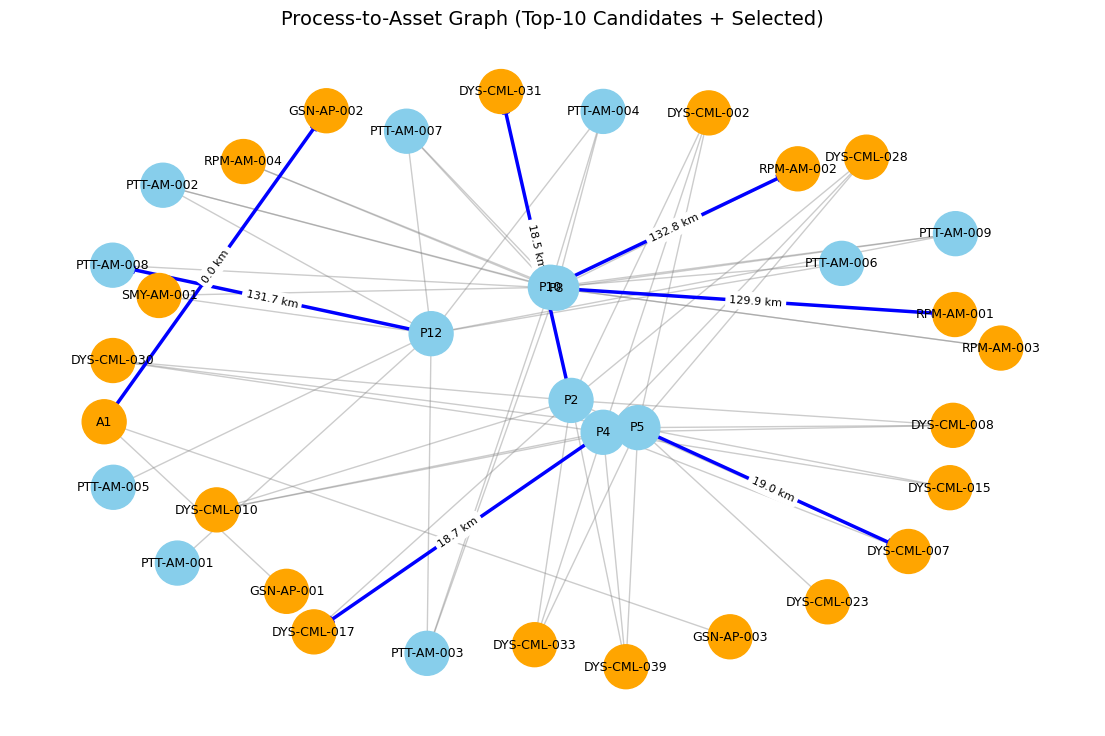

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# 모든 노드 추가 (공정 + 설비)
node_types = {}

# df_top10 기준으로 노드 전부 수집
nodes_from_df = set(df_top10["ProcessID"]) | set(df_top10["CandidateAssetID"])
for node_id in nodes_from_df:
    if node_id.startswith("P"):
        node_types[node_id] = "process"
    else:
        node_types[node_id] = "asset"
    G.add_node(node_id, type=node_types[node_id])

# 엣지 추가
for _, row in df_top10.iterrows():
    pid = row["ProcessID"]
    aid = row["CandidateAssetID"]
    dist = row["Distance (km)"]
    selected = row["Selected"]
    G.add_edge(pid, aid, weight=dist, selected=selected)

# 색상 매핑
color_map = ['skyblue' if G.nodes[n]["type"] == "process" else 'orange' for n in G.nodes]

# 레이아웃 및 시각화
pos = nx.spring_layout(G, seed=42, k=1)

plt.figure(figsize=(14, 9))
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=1000)
nx.draw_networkx_labels(G, pos, font_size=9)

# 엣지 분리
edges_selected = [(u, v) for u, v, d in G.edges(data=True) if d["selected"]]
edges_other = [(u, v) for u, v, d in G.edges(data=True) if not d["selected"]]

nx.draw_networkx_edges(G, pos, edgelist=edges_other, edge_color='gray', width=1, alpha=0.4, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=edges_selected, edge_color='blue', width=2.5, arrows=True)

# 선택 엣지에 거리 표시
edge_labels = {(u, v): f'{d["weight"]:.1f} km' for u, v, d in G.edges(data=True) if d["selected"]}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Process-to-Asset Graph (Top-10 Candidates + Selected)", fontsize=14)
plt.axis('off')
plt.show()


GraphSAGE기반 모델 학습

In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch.nn import Linear
from torch_geometric.data import Data

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.edge_predictor = Linear(2 * hidden_channels, 1)

    def forward(self, x, edge_index, edge_label_index):
        # 1. 노드 임베딩 생성
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        # 2. 엣지 양 끝 노드 임베딩 추출
        src = x[edge_label_index[0]]
        dst = x[edge_label_index[1]]

        # 3. 엣지 예측 (concat 후 FC)
        edge_feat = torch.cat([src, dst], dim=1)
        return torch.sigmoid(self.edge_predictor(edge_feat))


In [43]:
# 1. 노드 인덱스 매핑
node_to_idx = {node_id: i for i, node_id in enumerate(G.nodes)}
num_nodes = len(node_to_idx)

# 2. 노드 피처: 공정 1-hot, 설비 1-hot (2차원)
x = torch.zeros((num_nodes, 2))
for node_id, idx in node_to_idx.items():
    if node_id.startswith("P"):
        x[idx, 0] = 1  # 공정
    else:
        x[idx, 1] = 1  # 설비

# 3. 엣지 인덱스
edge_index = []
edge_label = []

for _, row in df_top10.iterrows():
    pid = row["ProcessID"]
    aid = row["CandidateAssetID"]
    selected = row["Selected"]

    # 공정 → 설비
    src = node_to_idx[pid]
    dst = node_to_idx[aid]
    edge_index.append([src, dst])
    edge_label.append(1 if selected else 0)

# Tensor 변환
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # [2, num_edges]
edge_label = torch.tensor(edge_label, dtype=torch.float)  # [num_edges]


In [44]:
print("x shape:", x.shape)
print("x unique values:", torch.unique(x))
print("x dtype:", x.dtype)
print("edge_index shape:", edge_index.shape)
print("max index:", edge_index.max().item())
print("num nodes:", x.shape[0])
print("edge_label shape:", edge_label.shape)
print("unique:", torch.unique(edge_label))
print("dtype:", edge_label.dtype)


x shape: torch.Size([36, 2])
x unique values: tensor([0., 1.])
x dtype: torch.float32
edge_index shape: torch.Size([2, 63])
max index: 35
num nodes: 36
edge_label shape: torch.Size([63])
unique: tensor([0., 1.])
dtype: torch.float32


In [45]:
from torch_geometric.data import Data

# 디버깅용 설정 (필요 시)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#device = torch.device("cpu")

# 라벨 정제 (0 or 1 only)
edge_label = edge_label.clone().detach()
edge_label[edge_label != 1.0] = 0.0

# 모델 초기화
model = GraphSAGEModel(in_channels=2, hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

# 데이터 객체 구성
data = Data(x=x, edge_index=edge_index)
data.edge_label_index = edge_index
data.edge_label = edge_label

# 학습 루프
for epoch in range(1, 11):
    model.train()
    optimizer.zero_grad()

    # forward
    pred = model(
        data.x.to(device),
        data.edge_index.to(device),
        data.edge_label_index.to(device)
    ).squeeze()

    # loss
    loss = criterion(pred, data.edge_label.to(device))
    loss.backward()
    optimizer.step()

    # 로그 출력
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f}")


Epoch   1 | Loss: 0.9243
Epoch   5 | Loss: 0.7302
Epoch  10 | Loss: 0.6940


In [46]:
model.eval()
with torch.no_grad():
    pred = model(
        data.x.to(device),
        data.edge_index.to(device),
        data.edge_label_index.to(device)
    ).squeeze().cpu().numpy()

# df_top10에 예측 점수 추가
df_top10["GNN_Score"] = pred

# 각 공정별로 예측 점수가 가장 높은 설비 추출
df_top10_sorted = (
    df_top10.sort_values(["ProcessID", "GNN_Score"], ascending=[True, False])
    .groupby("ProcessID")
    .head(10)  # 상위 10개 유지
    .reset_index(drop=True)
)

# 출력 예시 (표 형태)
import pandas as pd
import IPython
from IPython.display import display

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 0)
pd.set_option("display.max_colwidth", None)

display(df_top10_sorted[["ProcessID", "CandidateAssetID", "Selected", "GNN_Score"]])


,ProcessID,CandidateAssetID,Selected,GNN_Score
0,A1,GSN-AP-002,True,0.000649
1,A1,GSN-AP-001,False,0.000649
2,A1,GSN-AP-003,False,0.000649
3,P10,PTT-AM-002,False,0.001449
4,P10,PTT-AM-003,False,0.001449
5,P10,PTT-AM-004,False,0.001449
6,P10,PTT-AM-009,False,0.001449
7,P10,PTT-AM-007,False,0.001449
8,P10,PTT-AM-006,False,0.001449
9,P10,RPM-AM-002,True,0.000668


c:\Users\roux\miniconda3\envs\torch310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy  : 0.8889
Precision : 0.0000
Recall    : 0.0000
F1 Score  : 0.0000
ROC AUC   : 0.3622


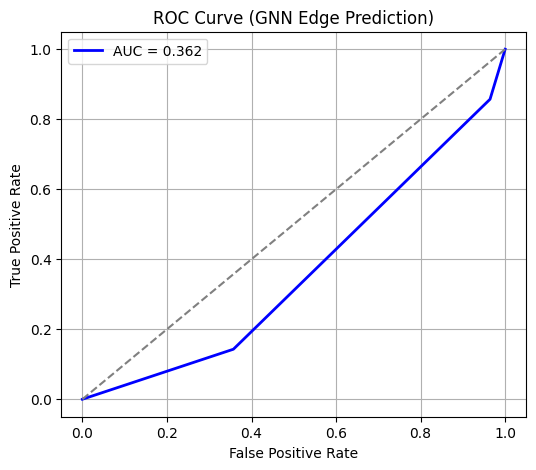

In [47]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# 1. 예측값: GNN_Score > 0.5 → 1, else 0
df_top10["GNN_Predicted"] = (df_top10["GNN_Score"] >= 0.5).astype(int)

# 정답
y_true = df_top10["Selected"].values
y_pred = df_top10["GNN_Predicted"].values
y_score = df_top10["GNN_Score"].values

# 2. 정량 평가 지표 출력
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_score)

print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"ROC AUC   : {auc:.4f}")

# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", color="blue", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (GNN Edge Prediction)")
plt.legend()
plt.grid(True)
plt.show()
